# GCNNによって隣接行列からノードの座標の予測する

## Colabで実行するときの設定

## 実験条件

- ネットワーク: GCNN
- 目的：隣接行列を生成した数字の予測
- edge weight: 使用
- epoch: 100
- 拡散時間t=20, ビーズの数nBeads=100
- 作った隣接行列：1~9の各クラスで100ずつ
- バッチサイズ：128

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
from scipy.io import mmread
from sklearn.model_selection import train_test_split
import random
import networkx as nx
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from torch_scatter import  scatter

# random seed
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## データの用意

### データの読み込み

In [2]:
test_run = True
add_noise = True

#データの読み込み
if test_run:
    # プログラムが動くかどうかのテスト用の小さいデータ．shape=（5*9, 32*32 + 1）
    adjMats = mmread("small_adjMats.mtx").toarray()
    targets = mmread("small_targets.mtx")
    coords = mmread("small_coords.mtx")
    epoch_num = 1
    batch_size = 128
else:
    # 本番用データ
    adjMats = mmread("adjMats.mtx").toarray()
    targets = mmread("targets.mtx")
    coords = mmread("coords.mtx")
    epoch_num = 100
    batch_size = 128

nBeads = int(np.sqrt(adjMats.shape[1]))
nDim = 2
# vggを使うためデータのshapeを(nSmaple*9, 1, nBeads,nBeads)にする.第2次元はチャネル数に相当する．
#adjMats = adjMats.reshape(adjMats.shape[0], 1, nBeads, nBeads)
adjMats = adjMats.reshape(adjMats.shape[0], nBeads, nBeads)
coords = coords.reshape(adjMats.shape[0], nBeads, nDim)

In [3]:
nonzero_idx = np.nonzero(adjMats)
n_nonzero = len(nonzero_idx[0])

# 読み込んだ隣接行列にノイズを加える
if add_noise:
    # ここでは非零要素（エッジがある部分）に標準正規分布に従うノイズを加えた
    adjMats[nonzero_idx] += np.random.randn(n_nonzero)

In [4]:
# 隣接行列の重みを変換して，ノード同士の距離が近い時は重みも小さくなるようにする(kamada kawaiと同じ)
# ここでは逆数や-1/2乗にしている
# この処理をすることで edge_weightを用いたときも学習できるようになったが理由は不明
p = -1.0
adjMats[nonzero_idx] = adjMats[nonzero_idx]**p


### (dataset,) dataloaderの作成

In [5]:
# PyG用のデータに変換

# とりあえずはPyGのDataset, In Memory Datasetを使わない簡易的な実装を用いる
data_list = []
for i, a in enumerate(adjMats):
    e_index = np.where(a > 0)

    # edge_weightを使うときはなぜか入力をfloatにしておかないとエラーになる
    x = torch.ones((nBeads, 1)).float()  # ノードに特徴量はないのでとりあえず1にしている

    edge_index = torch.tensor(e_index, dtype=torch.long)
    
    # edge_weightを使うときはなぜか入力をfloatにしておかないとエラーになる
    edge_attr = torch.tensor(a[e_index].reshape(-1,1)).float()

    y = int(targets[i]) - 1  ##pytorchではカテゴリは1th indexではなく0th indexでなければならない
    coord = torch.tensor(coords[i]).float()

    data_list.append(Data(x=x,edge_index=edge_index,edge_attr=edge_attr,y=y,coord=coord))

test_size = int(len(data_list) * 0.1)

trainval_data, test_data = train_test_split(data_list, test_size=test_size, shuffle=True)
train_data, val_data = train_test_split(trainval_data, test_size=test_size, random_state=0)

# dataloaderの作成    
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## モデルの定義

### ネットワークの定義

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO: 入力グラフのチャネル数への依存をなくす
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 48)
        self.conv4 = GCNConv(48, 64)
        self.conv5 = GCNConv(64, 96)
        self.conv6 = GCNConv(96, 128)
        self.linear1 = torch.nn.Linear(128,64)
        #TODO: 分類数への依存をなくす
        self.linear2 = torch.nn.Linear(64,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        #edge_weightとして用いるedge_attrのshapeが(n,1)だとうまくいかない．
        #edge_attr.shapeが(n,)だと動く．おそらくPyG側のバグ？
        edge_weight = torch.squeeze(data.edge_attr)
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv6(x, edge_index, edge_weight)
        x = F.relu(x)
        """
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        """
        #x = scatter(x, data.batch, dim=0, reduce="max")
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

### 学習

In [7]:
start = time.time()
# GPUの使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print("device:", device)

train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(epoch_num):
    train_loss = 0.0
    model.train()
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        prediction = model(batch)

        loss = criterion(prediction, batch.coord)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().item() * nDim
        if i % 10 == 9:
            progress_bar = '['+('='*((i+1)//10))+(' '*((train_size//100-(i+1))//10))+']'
            print('\repoch: {:d} loss: {:.3f}  {}'
                .format(
                    epoch + 1,
                    loss.cpu().item() * nDim,  # 表示するlossはノード間の距離の二条の平均
                    progress_bar),
                end="  ")

    print('\repoch: {:d} loss: {:.3f}'
        .format(epoch + 1, train_loss / math.ceil(train_size / batch_size)), end="  ")
    history["train_loss"].append(train_loss / math.ceil(train_size / batch_size))

    batch_num = 0
    loss = 0
    with torch.no_grad():
        model.eval()
        for data in val_loader:
            data = data.to(device)
            prediction = model(data)
            loss += criterion(prediction, data.coord) * nDim
            batch_num += 1

    history["val_loss"].append(loss.cpu().item()/batch_num)
    endstr = ' '*max(1,(train_size//1000-39))+"\n"
    print(f'Val Loss: {loss.cpu().item()/batch_num:.3f}',end=endstr)


print('Finished Training')
elapsed_time = time.time() - start
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))

device: cpu
epoch: 1 loss: 1.311  Val Loss: 1.292 
Finished Training
elapsed time: 0:00:04


## 可視化

#### 座標予測用の可視化

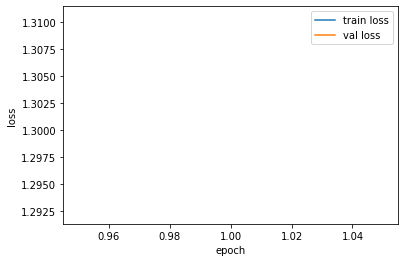

In [8]:
# 損失
plt.xlabel("epoch")
plt.ylabel("loss")

x = np.arange(epoch_num) + 1
plt.plot(x, history["train_loss"], label="train loss")
plt.plot(x, history["val_loss"], label="val loss")
plt.legend()
plt.show()

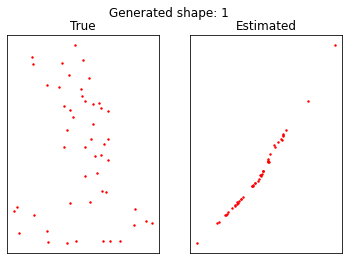

In [9]:
t_index = 0

node_list = list(range(nBeads))

# テストデータのノードの座標を予想
with torch.no_grad():
    model.eval()
    t_data = test_data[t_index].to(device)
    e_coords = model(t_data)
    
# 描画のためのグラフを作成
t_src, t_dst = np.where(adjMats[t_index].squeeze() > 0)
t_coords = coords[t_index]

G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(list(zip(t_src, t_dst)))

fig = plt.figure()
fig.suptitle("Generated shape: {}".format(targets[t_index, 0]))

ax1 = fig.add_subplot(1,2,1)
ax1.set_title("True")
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Estimated")

true_pos = dict(zip(node_list, t_coords))
#nx.draw_networkx(G, pos=true_pos, with_labels=False, ax=ax1,
#                 node_color="red", node_size=2)
nx.draw_networkx_nodes(G, pos=true_pos, ax=ax1, node_color="red", node_size=2)

estimated_pos = dict(zip(node_list, e_coords.cpu().detach().numpy()))
#nx.draw_networkx(G, pos=estimated_pos, with_labels=False, ax=ax2,
#                 node_color="red", node_size=2)
nx.draw_networkx_nodes(G, pos=estimated_pos, ax=ax2, node_color="red", node_size=2)

plt.show()

## 実験条件

In [10]:
nSmaples = len(adjMats)
t = 20

print("=====Simulation conditions=====")
print("目的：隣接町列を生成した数字の予測")
print("ネットワーク：GCNN")
print("Test run: {}".format(test_run))
print("Number of beads: {}".format(nBeads))
print("Number of samples for training: {}".format(nSmaples))
print("Add noise: {}".format(add_noise))
print("Number of epochs: {}".format(epoch_num))
print("Batch size: {}".format(batch_size))
print("Diffusion time: {}".format(t))

print("=====Results=====")
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))

=====Simulation conditions=====
目的：隣接町列を生成した数字の予測
ネットワーク：GCNN
Test run: True
Number of beads: 50
Number of samples for training: 900
Add noise: True
Number of epochs: 1
Batch size: 128
Diffusion time: 20
=====Results=====
elapsed time: 0:00:04
